训练模型、评估模型

主要得到：

训练好的模型、模型评估结果

# 读取数据和引入模块

In [86]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc,confusion_matrix,recall_score,precision_score,accuracy_score
import main
import variable_encode as ve
import variable_bin_methods as vb
import variable_bin_methods as varbin_meth
import pickle
import stat
import toad

In [87]:
data_train_woe = pd.read_csv('逻辑回归/data_train_woe.csv')
data_train=pd.read_csv('逻辑回归/data_train.csv')
data_train = data_train.iloc[:,1:]
data_train_woe = data_train_woe.iloc[:,1:]

In [88]:
X_train = data_train_woe.drop(columns = ['loan_status'])
x_train = data_train.drop(columns = ['loan_status'])
Y_train = data_train_woe['loan_status']
y_train = data_train['loan_status']

In [89]:
X_train.shape,Y_train.shape

((26313, 19), (26313,))

In [90]:
Y_train.value_counts()

0    19016
1     7297
Name: loan_status, dtype: int64

In [91]:
data_test_woe = pd.read_csv('逻辑回归/data_test_woe.csv')
data_test=pd.read_csv('逻辑回归/data_test.csv')
data_test_woe = data_test_woe.iloc[:,1:]
data_test = data_test.iloc[:,1:]

In [92]:
X_test = data_test_woe.drop(columns = ['loan_status'])
x_test = data_test.drop(columns = ['loan_status'])
Y_test = data_test_woe['loan_status']
y_test = data_test['loan_status']

In [93]:
X_test.shape,Y_test.shape

((6579, 19), (6579,))

In [94]:
Y_test.value_counts()

0    4777
1    1802
Name: loan_status, dtype: int64

# 模型训练

## 网格搜索

In [95]:
##初始化网格搜索
##penalty,选择使用哪种正则项来抑制过拟合,默认为'l2'，即使用L2正则
##fit_intercept,模型训练时是否添加截距项,默认为True，即添加截距项
##solver：字符串，用于选择不同的优化算法
##cv,交叉验证
##scoring,模型评估指标
##verbose：输出训练过程
##n_jobs：使用CPU个数
##param_grid，待搜索的全部参数组合
param={'C':[0.01,0.1,0.2,0.5,1,1.5,2],'class_weight':[{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}]}
gridsearch=sk.model_selection.GridSearchCV(estimator=LogisticRegression(random_state=0,fit_intercept=True,penalty='l2',solver='saga'),
                                          param_grid=param,cv=3,scoring='f1',n_jobs=-1,verbose=2)
gridsearch.fit(X_train,Y_train)
gridsearch.best_params_

Fitting 3 folds for each of 21 candidates, totalling 63 fits


{'C': 2, 'class_weight': {1: 3, 0: 1}}

## 训练模型

In [96]:
##正则项惩罚系数C,
##权重字典class_weight
LR_model=LogisticRegression(C=gridsearch.best_params_['C'],penalty='l2',solver='saga',class_weight=gridsearch.best_params_['class_weight'])
LR_model_fit=LR_model.fit(X_train,Y_train)

## 预测与评估

### 混淆矩阵

In [97]:
Y_pred_test = LR_model_fit.predict(X_test)
Y_pred_train=LR_model_fit.predict(X_train)
cnf_matrix = confusion_matrix(Y_test,Y_pred_test)
cnf_matrix = pd.DataFrame(cnf_matrix,index = ["标签为好","标签为坏"],columns = ['预测为好','预测为坏'])
cnf_matrix

预测为好  预测为坏
标签为好  2694  2083
标签为坏   460  1342

### 评估指标

In [98]:
accuracy=sk.metrics.accuracy_score(Y_test,Y_pred_test)
Y_score=LR_model_fit.predict_proba(X_test)[:,1]
auc=sk.metrics.roc_auc_score(Y_test,Y_score)
fpr,tpr,threshold=sk.metrics.roc_curve(Y_test,Y_score)
ks=max([trp_ - fpr_ for trp_, fpr_ in zip(tpr, fpr)])
estimate=pd.DataFrame([[accuracy,auc,ks]],columns=['准确率','AUC','KS值'])
estimate

准确率       AUC       KS值
0  0.613467  0.713026  0.314816

### ks、roc曲线 

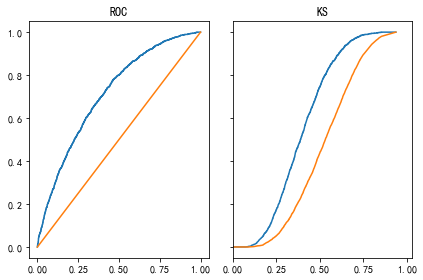

In [99]:
%matplotlib inline
Y_proba = LR_model_fit.predict_proba(X_test)
fig,(axe1,axe2) = plt.subplots(1,2,sharey = True)
for i in range(len(np.unique(Y_test))):
    fpr,tpr,thresholds = roc_curve(Y_test,Y_proba[:,i],pos_label = i)
axe1.plot(fpr,tpr)
axe1.plot([0,1],[0,1])
axe1.set_title('ROC')
axe2.plot(1 - thresholds,tpr,label = 'TPR')
axe2.plot(1 - thresholds,fpr,label = 'FPR')
plt.xlim(0,)
axe2.set_title('KS')
plt.tight_layout()
plt.show()

### 计算权重与截距 

In [100]:
data_woe_train,dict_woe_map_train,dict_iv_train,var_woe_name_train=ve.woe_encode(x_train,r"逻辑回归",list(x_train.columns),y_train,filename='woe',flag='train')
data_woe_test,var_woe_name=ve.woe_encode(x_test,r"逻辑回归",list(x_test.columns),y_test,filename='woe',flag='test')
var_woe_name.append('intercept')
##提取权重
weight_value = list(LR_model_fit.coef_.flatten())
##提取截距项
weight_value.extend(list(LR_model_fit.intercept_))
dict_params = dict(zip(var_woe_name,weight_value))
print(dict_params)

{'installment_BIN_woe': 1.0129301900402226, 'annual_inc_BIN_woe': 0.17866129301757452, 'dti_BIN_woe': 0.8563450811793291, 'revol_bal_BIN_woe': -0.24757781875443818, 'open_il_24m_BIN_woe': -0.02421761138008454, 'mths_since_rcnt_il_BIN_woe': 0.40968881013859765, 'all_util_BIN_woe': 0.4626827660443838, 'avg_cur_bal_BIN_woe': 0.4810214993339307, 'bc_open_to_buy_BIN_woe': 0.8447590347718568, 'mo_sin_old_il_acct_BIN_woe': 0.06161200080196105, 'mo_sin_old_rev_tl_op_BIN_woe': 0.5537055500684598, 'mort_acc_BIN_woe': 0.26789245774268894, 'num_il_tl_BIN_woe': 0.8995672982630656, 'num_rev_tl_bal_gt_0_BIN_woe': 1.0670641083973056, 'percent_bc_gt_75_BIN_woe': 0.1156879698521975, 'term_BIN_woe': 0.9685868190146028, 'emp_length_BIN_woe': 0.9294140490182861, 'home_ownership_BIN_woe': 0.4781884499381337, 'verification_status_BIN_woe': 0.6938080762722155, 'intercept': 0.1378050349530253}


### 评分卡

In [101]:
dict_cont_bin_read = open('逻辑回归/dict_cont_bin.pkl','rb')
dict_cont_bin = pickle.load(dict_cont_bin_read)
dict_cont_bin_read.close()

dict_disc_bin_read = open('逻辑回归/dict_disc_bin.pkl','rb')
dict_disc_bin = pickle.load(dict_disc_bin_read)
dict_disc_bin_read.close()

In [102]:
var_woe_name.append('intercept')
dict_param=dict(zip(var_woe_name,weight_value))
df_score,dict_bin_score,params_A,params_B,score_base=main.create_score(dict_woe_map_train, dict_param, dict_cont_bin,dict_disc_bin)
pd.options.display.max_rows=None
df_score

bin   woe_val  score    total                               var_name  \
0   5.0  0.265857   -8.0  11068.0                           526.9645_inf   
1   3.0 -0.028432    1.0   5744.0  237.88150000000002_334.24250000000006   
2   4.0  0.086491   -3.0   8072.0            334.24250000000006_526.9645   
3   2.0 -0.309211    9.0   3923.0  160.79270000000002_237.88150000000002   
4   1.0 -0.759782   22.0   4085.0                -inf_160.79270000000002   
0   3.0 -0.019048    0.0  10655.0                      56273.64_89306.22   
1   4.0 -0.188655    1.0  11237.0                           89306.22_inf   
2   2.0  0.163085   -1.0   9243.0                      29532.98_56273.64   
3   1.0  0.355267   -2.0   1757.0                          -inf_29532.98   
0   2.0 -0.087062    2.0   6875.0             13.952100000000002_19.1505   
1   3.0  0.142089   -4.0  11018.0             19.1505_31.171800000000005   
2   4.0  0.382184   -9.0   4024.0                 31.171800000000005_inf   
3   1.0 -0.262734    6.0  10884.0                -inf_13.952100000000002   
4   5.0  0.284088   -7.0     91.0                                nan_nan   
0   2.0 -0.086364   -1.0   5420.0                          3241.0_6532.4   
1   4.0  0.005980    0.0   3618.0                        25810.6_46499.4   
2   3.0  0.097320    1.0  16896.0                         6532.4_25810.6   
3   1.0 -0.208999   -1.0   5209.0                            -inf_3241.0   
4   5.0 -0.126447   -1.0   1749.0                            46499.4_inf   
0   4.0 -0.194808   -0.0   5034.0                              3.04_7.04   
1   3.0 -0.057750   -0.0  12178.0                              1.12_3.04   
2   2.0  0.033929    0.0   9214.0                              0.16_1.12   
3   1.0  0.193622    0.0   6101.0                              -inf_0.16   
4   5.0  0.216916    0.0    365.0                               7.04_inf   
0   3.0  0.064270   -1.0   9364.0                              12.0_29.0   
1   2.0 -0.118297    1.0  17745.0                               1.5_12.0   
2   4.0  0.189605   -2.0   3982.0                               29.0_inf   
3   1.0  0.112703   -1.0   1065.0                               -inf_1.5   
4   5.0  0.626040   -7.0    736.0                                nan_nan   
0   2.0 -0.184960    2.0   8100.0                            28.36_47.53   
1   4.0  0.215744   -3.0  14886.0                              57.47_inf   
2   3.0  0.025368   -0.0   5843.0                            47.53_57.47   
3   1.0 -0.593422    8.0   4049.0                             -inf_28.36   
4   5.0 -0.988093   13.0     14.0                                nan_nan   
0   1.0  0.195275   -3.0  18303.0                           -inf_10541.6   
1   2.0 -0.201672    3.0  10514.0                       10541.6_32802.21   
2   3.0 -0.454910    6.0   4069.0                           32802.21_inf   
3   4.0 -0.140795    2.0      6.0                                nan_nan   
0   4.0 -0.597194   15.0   5541.0                           32108.24_inf   
1   1.0  0.332643   -8.0   9416.0                           -inf_4550.56   
2   2.0  0.101228   -2.0   7846.0                       4550.56_11739.52   
3   5.0  0.118818   -3.0    506.0                                nan_nan   
4   3.0 -0.147578    4.0   9583.0                      11739.52_32108.24   
0   4.0 -0.094768    0.0  23467.0                  90.71000000000001_inf   
1   3.0  0.125121   -0.0   6765.0                34.61_90.71000000000001   
2   2.0  0.706503   -1.0    163.0                            32.74_34.61   
3   1.0  0.353501   -1.0   1761.0                             -inf_32.74   
4   5.0  0.626040   -1.0    736.0                                nan_nan   
0   3.0 -0.119698    2.0  19335.0                             138.06_inf   
1   1.0  0.328713   -5.0   6340.0                             -inf_84.68   
2   2.0  0.007210   -0.0   7217.0                           84.68_138.06   
0   1.0  0.260678   -2.0  14223.0                   

### 样本评分 

In [103]:
##计算样本评分
data3=pd.read_csv('逻辑回归/data3.csv')
df_all_score = main.cal_score(data3,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)

### 评分区间生成 

In [104]:
##简单的分数区间计算
good_total = sum(df_all_score.target == 0)  
bad_total = sum(df_all_score.target == 1)
score_bin = np.arange(350,600,25)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
total_num=[]
##取出分数区间的样本
for i in range(len(score_bin)-1):
    if score_bin[i+1] == 650:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score <= score_bin[i+1]) 
    else:
        index_1 = (df_all_score.score >= score_bin[i]) &(df_all_score.score < score_bin[i+1]) 
        df_temp = df_all_score.loc[index_1,['target','score']]
        ##计算该分数区间的指标
        good_num.append(sum(df_temp.target==0))
        bad_num.append(sum(df_temp.target==1))
        total_num.append(sum(df_temp.target==0)+sum(df_temp.target==1))
        ##区间样本率
        bin_rate.append(df_temp.shape[0]/df_all_score.shape[0]*100)
        ##坏样本率
        bad_rate.append(df_temp.target.sum()/df_temp.shape[0]*100)
        ##以该分数为注入分数的ks值
        ks.append(sum(bad_num[0:i+1])/bad_total-sum(good_num[0:i+1])/good_total)

In [105]:
df_result = pd.DataFrame({'total_num':total_num,'good_num':good_num,'bad_num':bad_num,'bin_rate':bin_rate,'bad_rate':bad_rate})
df_result

total_num  good_num  bad_num   bin_rate    bad_rate
0          0         0        0   0.000000         NaN
1          1         0        1   0.003040  100.000000
2        151        48      103   0.459078   68.211921
3       2638      1239     1399   8.020187   53.032600
4      10603      6491     4112  32.235802   38.781477
5      12684      9833     2851  38.562568   22.477137
6       5768      5180      588  17.536179   10.194175
7        992       948       44   3.015931    4.435484
8         55        54        1   0.167214    1.818182